$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\mcH}{\mathcal{H}}
$$

# Tutorial: testing factor models with ``mosaicperm``

## 1. Review of mosaic factor tests

For observations $t=1, \dots, T$, suppose we observe asset returns $Y_t \in \R^p$ which we believe follow the factor model: 

$$Y_t = L_t X_t + \epsilon_t $$

where:

- $X_t \in \R^k$ are unobserved factor variables.
 
- $L_t \in \R^{p \times k}$ are *prespecified* factor exposures. For example, many financial firms such as MSCI and BlackRock routinely distribute exposure matrices for financial risk models. 

- $\epsilon_t \in \R^p$ are residuals which capture the variance in $Y_t$ which cannot be explained by the factors. 

The goal of a factor model is to explain common variation among the outcomes. Thus, we say that a factor model fits if the components of $\epsilon_t$ are independent:

$$\mathcal{H}_0 : \epsilon_t \text{ has independent components}, \text{ for } t=1, \dots, T. $$

``mosaicperm`` contains methods to *test* this null hypothesis, i.e., to test if a factor model reliably explains the common correlations among outcomes. These mosaic permutation tests have a few desirable properties:

1. They allow the use of black-box machine learning/statistical algorithms to find violations of the null.

    - This property helps analysts quickly understand when (e.g.) a financial risk model is no longer reliable. 

2. They exactly control the false positive rate, i.e., the probability of rejecting a well-fitting factor model.
    
    - This property helps prevent analysts from unnecessarily rebuilding accurate models, which can waste resources and increase risk.

**Note**:  ``mosaicperm`` is designed to test if $\mcH_0$ holds for a "prespecified" choice of exposures $L_t$, i.e., whether one's own factor model actually fits the data. Other methods often test whether $\mcH_0$ holds for some unknown choice of $L_t \in \R^{p \times k}$. This latter problem has does not accomplish our goal: if one's own risk model is highly misspecified, it is of little comfort to know that some unknown choice of factor loadings is well-specified.

## 2. Example application

Below, we illustrate the use of ``mosaicperm`` on a toy factor risk model for US equity data from 2018 through 2022. This "toy model" is not a serious model, but unlike real models used in industry (e.g. from BlackRock/MSCI), using it allows us to share the data publicly.

There are three key inputs to the analysis:
- The ``outcomes``: a ``n_timepoints`` x ``n_assets`` array of (log) returns for each asset, i.e., $Y_t$ in the notation above.
- The ``exposures``: ``n_assets`` x ``n_factors`` array of exposures for each asset. This can also be a 3D array of the form ``n_timepoints`` x ``n_assets`` x ``n_factors`` if the exposures change with time, although in this application they do not.
- A callable test statistic (``test_stat``) which takes an array of estimated residuals as an input and produces one or more test statistics measuring evidence against the null as an output. In this analysis, we use ``mosaicperm.statistics.mean_maxcorr_stat``, which returns the maximum estimated absolute correlation between asset $j$ and all other assets, averaged over all assets $j$.

### 2.1 Load sample dataset

In [1]:
import sys
sys.path.insert(0, "../../")
import numpy as np
import pandas as pd
import mosaicperm as mp
from datetime import datetime

# Load sample dataset from mosaicperm
returns, exposures = mp.utilities.load_sample_dataset()
returns = returns.loc[returns.index >= datetime(year=2018, month=1, day=1)]
logreturns = np.log(returns)

The log returns are for 488 stocks in the S\&P 500 from 2018 through 2022.

In [2]:
print(logreturns[['A', 'AAL', 'AAP', 'OGN']].head().to_markdown())

| Date                |           A |          AAL |         AAP |   OGN |
|:--------------------|------------:|-------------:|------------:|------:|
| 2018-01-02 00:00:00 | -0.00936318 | -0.0182828   | -0.0622224  |   nan |
| 2018-01-03 00:00:00 | -0.0251255  |  0.0123423   | -0.00900829 |   nan |
| 2018-01-04 00:00:00 |  0.00752967 | -0.0062851   | -0.0362342  |   nan |
| 2018-01-05 00:00:00 | -0.0158619  |  0.000379731 | -0.0105745  |   nan |
| 2018-01-08 00:00:00 | -0.00214365 |  0.00992565  |  0.00706718 |   nan |


Note there is some missing data, e.g., "OGN" returns are not available until mid 2021. ``mosaicperm`` will automatically handle this.

The exposures include indicator factors for various sectors of the US economy, as well as indicators for REITs, common stocks, and large/mid cap stocks, e.g.:

In [3]:
print(exposures.iloc[:, 0:3].head().to_markdown())

| Symbol   |   communication services |   consumer discretionary |   consumer staples |
|:---------|-------------------------:|-------------------------:|-------------------:|
| A        |                        0 |                        0 |                  0 |
| AAL      |                        0 |                        0 |                  0 |
| AAP      |                        0 |                        1 |                  0 |
| AAPL     |                        0 |                        0 |                  0 |
| ABBV     |                        0 |                        0 |                  0 |


### 2.2 Test goodness of fit for the whole model

Below we show how to test goodness-of-fit for the whole model.

In [4]:
mpt = mp.factor.MosaicFactorTest(
    outcomes=logreturns.values,
    exposures=exposures.values,
    test_stat=mp.statistics.mean_maxcorr_stat,
)
mpt.fit().summary()

  0%|          | 0/500 [00:00<?, ?it/s]

statistic              0.366893
null_statistic_mean    0.190349
p_value                0.001996
dtype: float64

The p-value is highly significant, suggesting (unsurprisingly) that this toy model does not fully explain correlations among asset returns. We can also repeat this analysis in a sliding window across time:

  0%|          | 0/500 [00:00<?, ?it/s]

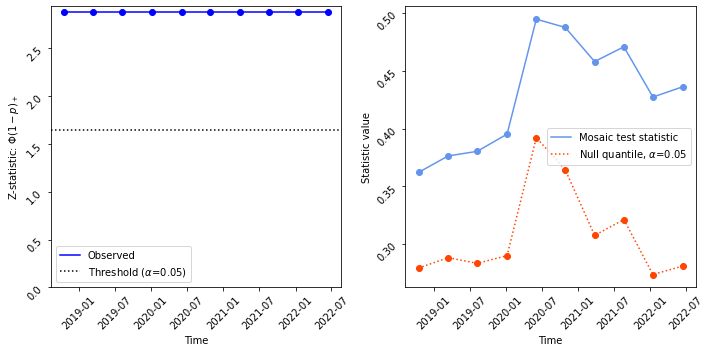

In [5]:
import matplotlib.pyplot as plt

mpt.fit_tseries(nrand=500, n_timepoints=10, window=200)
fig, axes = mpt.plot_tseries(
    time_index=returns.index, show_plot=False, figsize=(10, 5))
fig.patch.set_facecolor("white")
for ax in axes:
    ax.tick_params(labelrotation=45)
plt.tight_layout()
plt.show()

We find above that at all timepoints the model does not fit properly.

### 2.3 Using a custom test statistic

``mosaicperm`` makes it easy to plug in a custom test statistic. For example, below we define a custom maximum correlation statistic based on a Ledoit-Wolf covariance estimate.

In [6]:
from sklearn.covariance import LedoitWolf

def custom_test_stat(residuals):
    """
    Custom test statistic using LedoitWolf estimation.
    """
    # Fit LW estimator
    lw = LedoitWolf().fit(residuals)
    cov = lw.covariance_
    # Construct correlation matrix
    scale = np.sqrt(np.diag(cov))
    scale[scale == 0] = 1
    corr = cov / np.outer(scale, scale)
    # Return maximum absolute correlation
    return np.abs(corr - np.eye(corr.shape[0])).max()

In [7]:
mpt_lw = mp.factor.MosaicFactorTest(
    outcomes=logreturns.values,
    exposures=exposures.values,
    test_stat=custom_test_stat,
)
mpt_lw.fit(nrand=100).summary()

  0%|          | 0/100 [00:00<?, ?it/s]

statistic              0.741092
null_statistic_mean    0.286842
p_value                0.009901
dtype: float64

### 2.4 Test goodness of fit sector-by-sector

To understand the null violations, we can also apply the mosaic permutation test to various individual sectors within the economy, as is done below.

In [8]:
np.random.seed(1234)
from tqdm.auto import tqdm

# Sectors
all_sectors = exposures.columns[0:11].tolist()
# Initialize output
observed_stats = []
null_stats = []
# Loop through and run sector-by-sector
for sector in tqdm(all_sectors):
    # Only consider the assets in th esector
    flags = exposures[sector] == 1
    mpt_sector = mp.factor.MosaicFactorTest(
        outcomes=logreturns.T[flags].T.values,
        exposures=exposures.loc[flags].values,
        test_stat=mp.statistics.mean_maxcorr_stat,
    )
    # Fit 
    mpt_sector.fit(nrand=1000, verbose=False)
    pval = np.around(mpt_sector.pval, 3)
    # Save core output
    sector_name = sector.capitalize() + f"\n({int(flags.sum())} assets, pval={pval})"
    observed_stats.append(
        [mpt_sector.statistic, sector_name, 'Observed test statistic']
    )
    # Save null statistics
    null_df = pd.DataFrame(mpt_sector.null_statistics, columns=['statistic'])
    null_df['sector'] = sector_name
    null_df['label'] = 'Null statistics'
    null_stats.append(null_df)

# Concatenate dataframes
observed_stats = pd.DataFrame(
    observed_stats, columns=['statistic', 'sector', 'label']
)
null_stats = pd.concat(null_stats)

  0%|          | 0/11 [00:00<?, ?it/s]

The plot below finds strong evidence against the null in some sectors. In others, we are unable to reject the null in others. Of course, the latter results do not prove the null holds; they could also indicate a lack of statistical power.

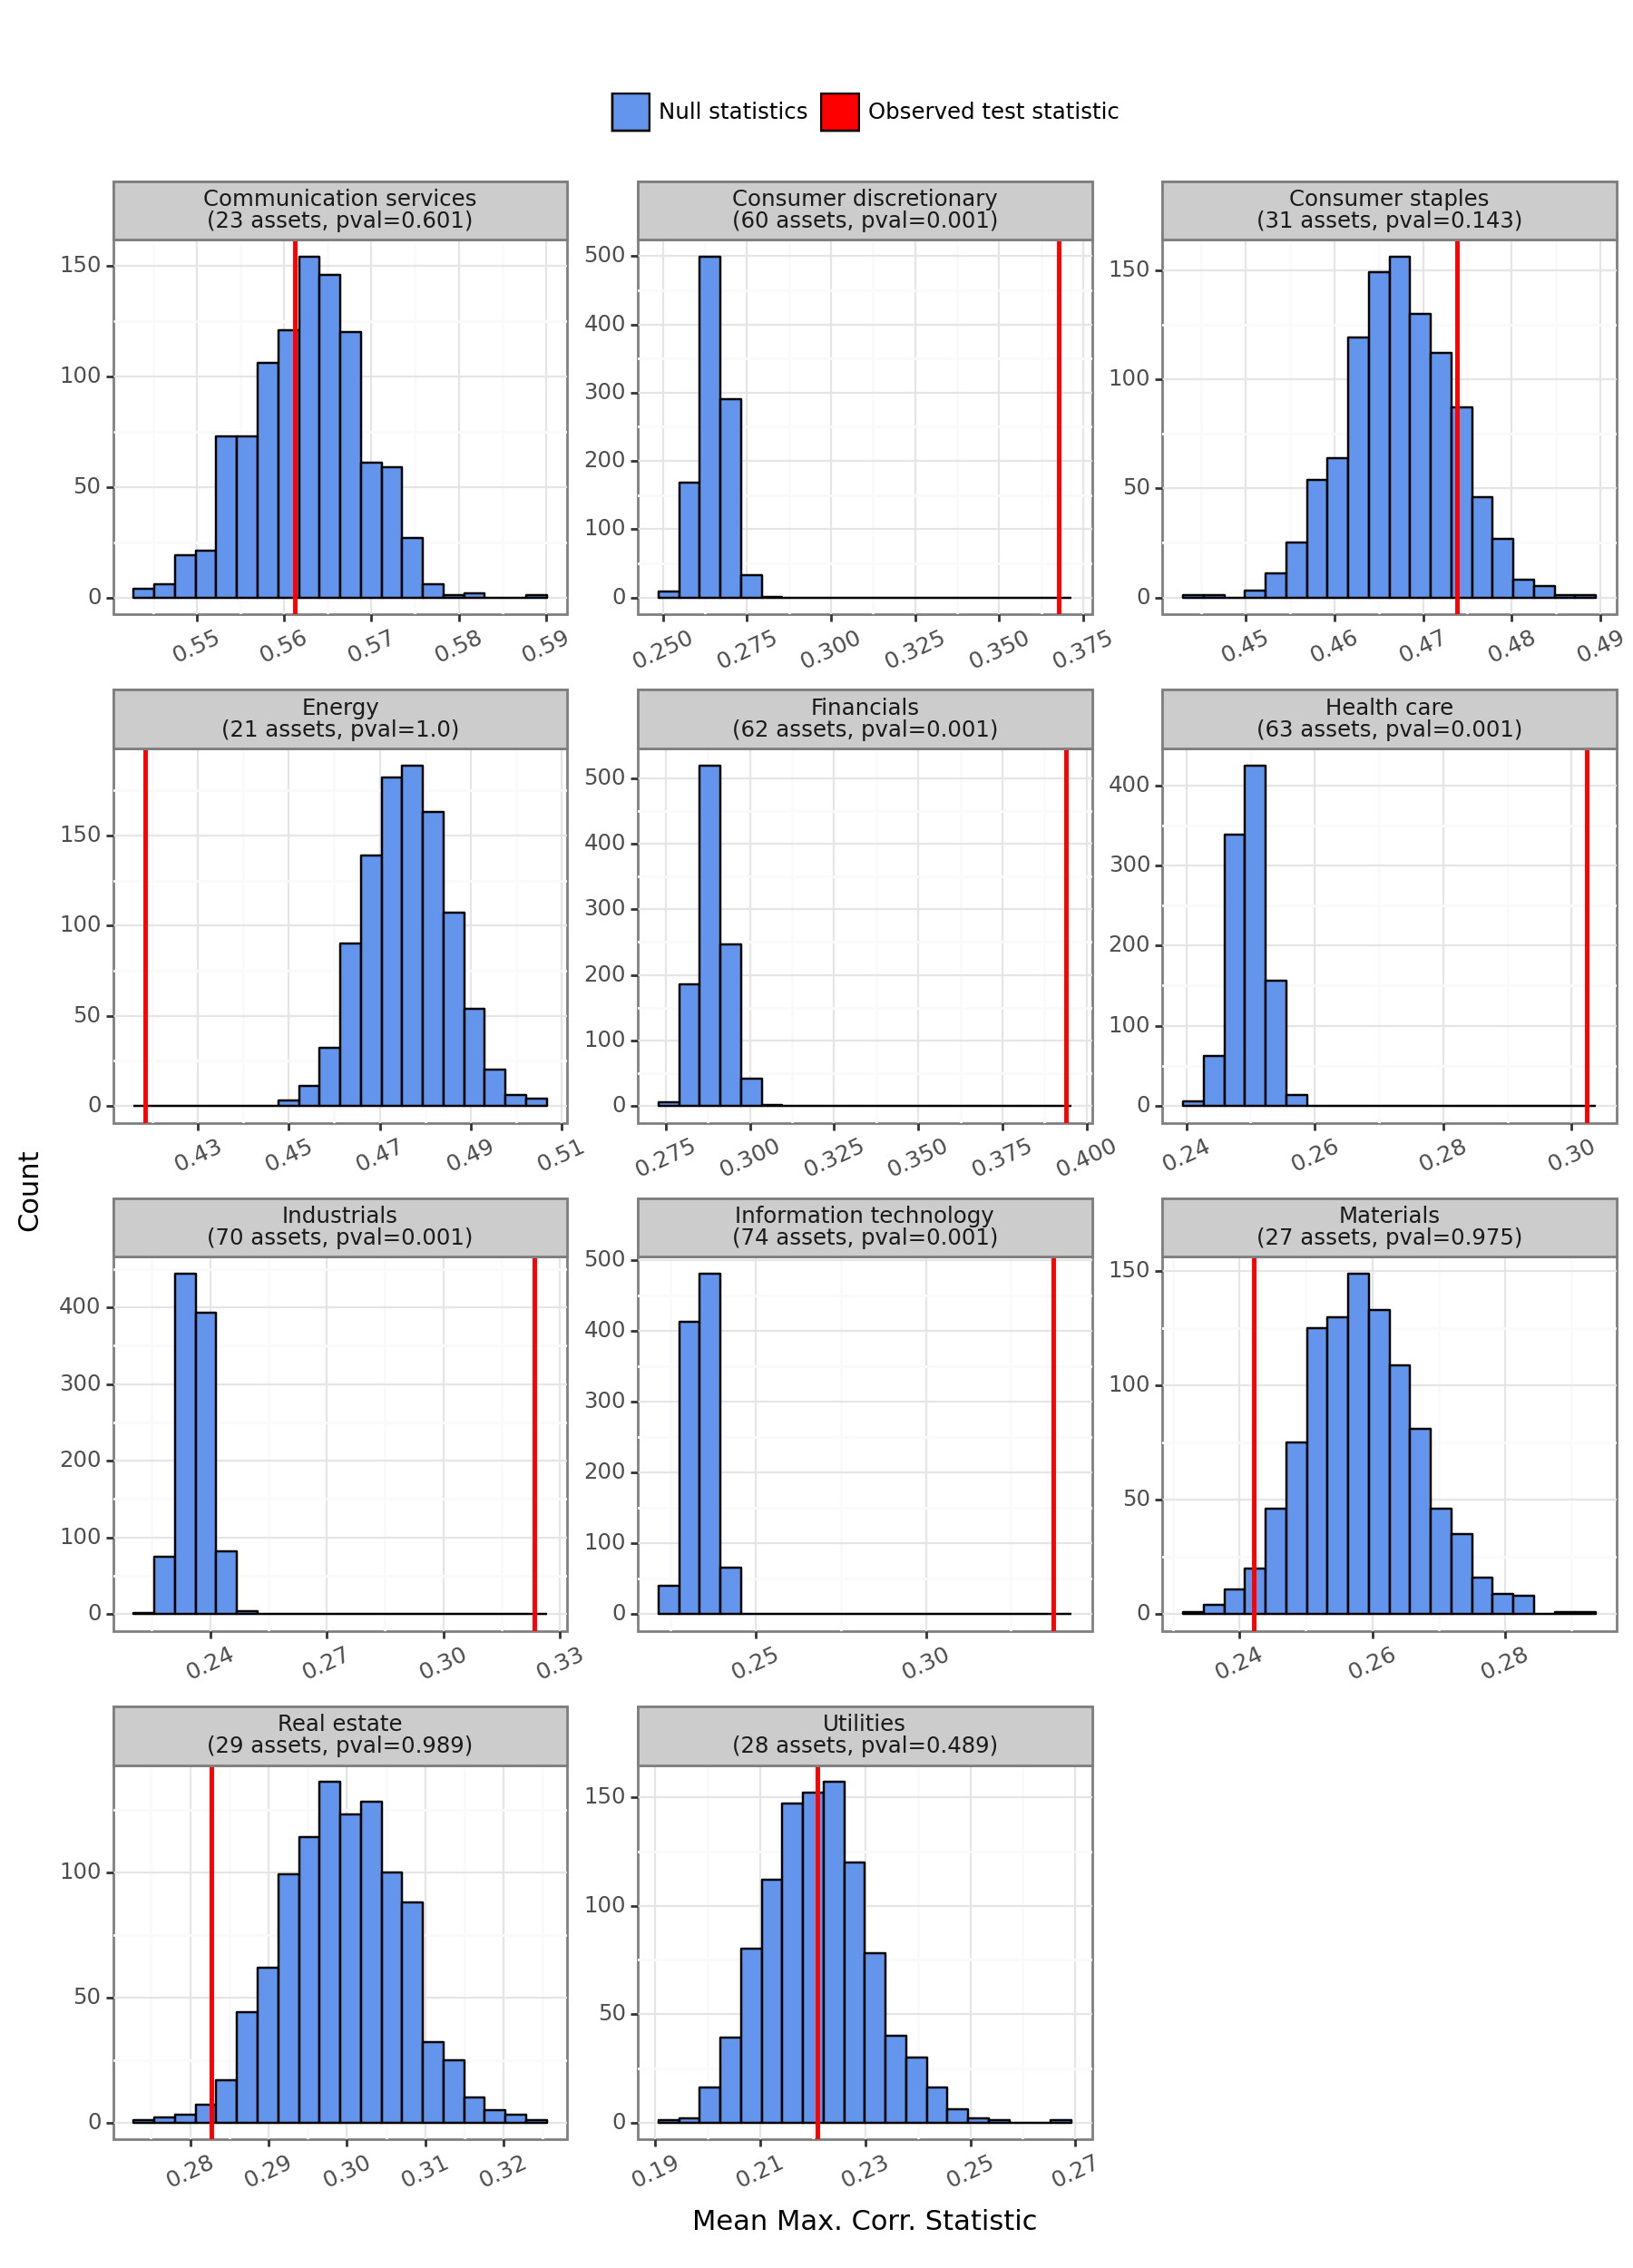

In [16]:
# Plot results with plotnine
from plotnine import *
g = (
    ggplot(
        null_stats,
        aes(x='statistic', fill='label')
    )
    + geom_histogram(bins=20, color='black') 
    + geom_vline(
        data=observed_stats,
        mapping=aes(xintercept='statistic', fill='label'),
        size=1, color='red',
    )
    + facet_wrap("~sector", scales='free', ncol=3)
    + theme_bw()
    + theme(
        figure_size=(9, 12.5), 
        axis_text_x=element_text(size=9, rotation=25),
        legend_position='top'
    )
    + labs(x='Mean Max. Corr. Statistic', fill='', y='Count')
    + scale_fill_manual(['cornflowerblue', 'red'])
)
print(g)

### 2.5 Using an $R^2$ for out-of-sample prediction error as the test statistic

One practical way to test $\mcH_0$ is to test whether several augmented model candidates improve model fit. This can be done by splitting the data, estimating new candidate exposures on the first fold of the data, and using the ``MosaicBCV`` class to test for significance on the second fold of the data, as shown below.

In [10]:
# estimate candidate exposures on the first half of the data via sparse PCA
n0 = int(0.5 * logreturns.shape[0])
resid0 = mp.factor.ols_residuals(logreturns.fillna(0).values[0:n0], exposures.values)
new_exposure_candidates = mp.statistics.approximate_sparse_pcas(
    np.corrcoef(resid0.T), quantiles=np.array([0.1, 0.5, 0.9])
)
new_exposure_candidates.shape

(3, 488)

Above, ``new_exposure_candidates`` contains 3 potential additional exposure vectors which are $10\%, 50\%$ and $90\%$ sparse.

In [11]:
# Check if any of the new exposures improve model fit
mpt_bcv = mp.factor.MosaicBCV(
    outcomes=logreturns.iloc[n0:].values,
    exposures=exposures.values,
    new_exposures=new_exposure_candidates,
)
mpt_bcv.fit(nrand=500)
print(mpt_bcv.summary().to_markdown())

  0%|          | 0/500 [00:00<?, ?it/s]

| Statistic type              |   statistic |   null_statistic_mean |    p_value |
|:----------------------------|------------:|----------------------:|-----------:|
| Adaptive z-stat             |  20.5983    |            0.19269    | 0.00199601 |
| $R^2$ for candidate model 0 |   0.0141414 |           -0.00294503 | 0.00199601 |
| $R^2$ for candidate model 1 |   0.0386417 |           -0.00366249 | 0.00199601 |
| $R^2$ for candidate model 2 |   0.047254  |           -0.00435839 | 0.00199601 |


We see that the out-of-sample $R^2$ for the third candidate model is the highest, and that all three new exposure vectors have positive $R^2$, indicating some model improvement. The "adaptive z-stat" row aggregates evidence against the null across all three exposure vectors and finds statistically significant evidence against the null.

**Important warning**: In general, the mosaic p-value may be significant even if the $R^2$ for each candidate exposure is negative. The reason for this is that sometimes, we can detect that the null fails to hold even without knowing how to improve the model---i.e., if the null $\mcH_0$ really held, we would expect the $R^2$'s to be even *more* negative. As a result, a significant p-value is not definitive proof that one can improve the model, but only evidence that there are unexplained correlations among the assets.